# Class Balance Analysis After Preprocessing

Este notebook analiza el balanceo de clases del dataset TACO después del preprocesamiento y splits.

## Objetivos:
- Visualizar distribución de clases en train/val/test
- Identificar clases minoritarias y mayoritarias
- Analizar co-ocurrencia de clases (multi-label)
- Calcular métricas de imbalance (Gini, ratios)
- Evaluar efectividad del stratified split

---

## 1. Importar Librerías

In [31]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from collections import Counter, defaultdict

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de tamaño de figuras
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Cargar Datos del Dataset

### IMPORTANTE: Reinicia el kernel antes de ejecutar este notebook para cargar el dataset más reciente

In [ ]:
# Rutas
processed_dir = Path('../../data/processed')
stats_file = processed_dir / 'dataset_stats.json'

# Cargar estadísticas
if stats_file.exists():
    with open(stats_file, 'r') as f:
        stats = json.load(f)
    print("Estadísticas cargadas correctamente")
    print(f"\nTotal de clases: {stats['total']['categories']}")
    print(f"Total de anotaciones: {stats['total']['annotations']}")
    print(f"Total de imágenes: {stats['total']['images']}")
    
    # Mostrar versión del dataset
    if 'version_info' in stats:
        print(f"\nVERSION DEL DATASET: {stats['version_info']['version']}")
        print(f"Timestamp: {stats['version_info']['timestamp']}")
        print(f"Stratify: {stats['version_info']['parameters']['stratify']}")
        print(f"Minority threshold: {stats['version_info']['parameters']['minority_threshold']}")
else:
    print("No se encontró dataset_stats.json")
    print("Ejecuta: python scripts/prepare_data.py primero")

# Cargar annotations de cada split
def load_annotations(split):
    ann_file = processed_dir / split / 'annotations.json'
    if ann_file.exists():
        with open(ann_file, 'r') as f:
            return json.load(f)
    return None

train_data = load_annotations('train')
val_data = load_annotations('val')
test_data = load_annotations('test')

print(f"\nSplits cargados:")
print(f"  Train: {len(train_data['images']) if train_data else 0} imágenes")
print(f"  Val:   {len(val_data['images']) if val_data else 0} imágenes")
print(f"  Test:  {len(test_data['images']) if test_data else 0} imágenes")

Estadísticas cargadas correctamente

Total de clases: 60
Total de anotaciones: 4784
Total de imágenes: 1500

Splits cargados:
  Train: 1049 imágenes
  Val:   226 imágenes
  Test:  225 imágenes


## 3. Análisis de Distribución por Clase

In [33]:
# Crear mapeo de categorías
categories = {cat['id']: cat['name'] for cat in train_data['categories']}

# Contar anotaciones por clase en cada split
def count_annotations_by_class(data, categories):
    counts = {cat_id: 0 for cat_id in categories.keys()}
    for ann in data['annotations']:
        counts[ann['category_id']] += 1
    return counts

train_counts = count_annotations_by_class(train_data, categories)
val_counts = count_annotations_by_class(val_data, categories)
test_counts = count_annotations_by_class(test_data, categories)

# Crear DataFrame
df_distribution = pd.DataFrame({
    'Class': [categories[cat_id] for cat_id in categories.keys()],
    'Train': [train_counts[cat_id] for cat_id in categories.keys()],
    'Val': [val_counts[cat_id] for cat_id in categories.keys()],
    'Test': [test_counts[cat_id] for cat_id in categories.keys()]
})

df_distribution['Total'] = df_distribution['Train'] + df_distribution['Val'] + df_distribution['Test']
df_distribution = df_distribution.sort_values('Total', ascending=False)

print("Top 10 clases más frecuentes:")
print(df_distribution.head(10))
print("\nTop 10 clases menos frecuentes:")
print(df_distribution.tail(10))

Top 10 clases más frecuentes:
                    Class  Train  Val  Test  Total
59              Cigarette    427  170    70    667
58       Unlabeled litter    399   59    59    517
36           Plastic film    323   64    64    451
5    Clear plastic bottle    199   44    42    285
29          Other plastic    166   60    47    273
39  Other plastic wrapper    175   53    32    260
12              Drink can    156   39    34    229
7      Plastic bottle cap    146   29    34    209
55          Plastic straw    100   13    44    157
9            Broken glass     87   51     0    138

Top 10 clases menos frecuentes:
                   Class  Train  Val  Test  Total
37        Six pack rings      2    3     0      5
44            Tupperware      3    0     1      4
48       Plastic glooves      1    2     1      4
56           Paper straw      4    0     0      4
41     Polypropylene bag      2    0     1      3
19             Pizza box      2    1     0      3
1                Battery  

## 4. Visualizaciones Interactivas

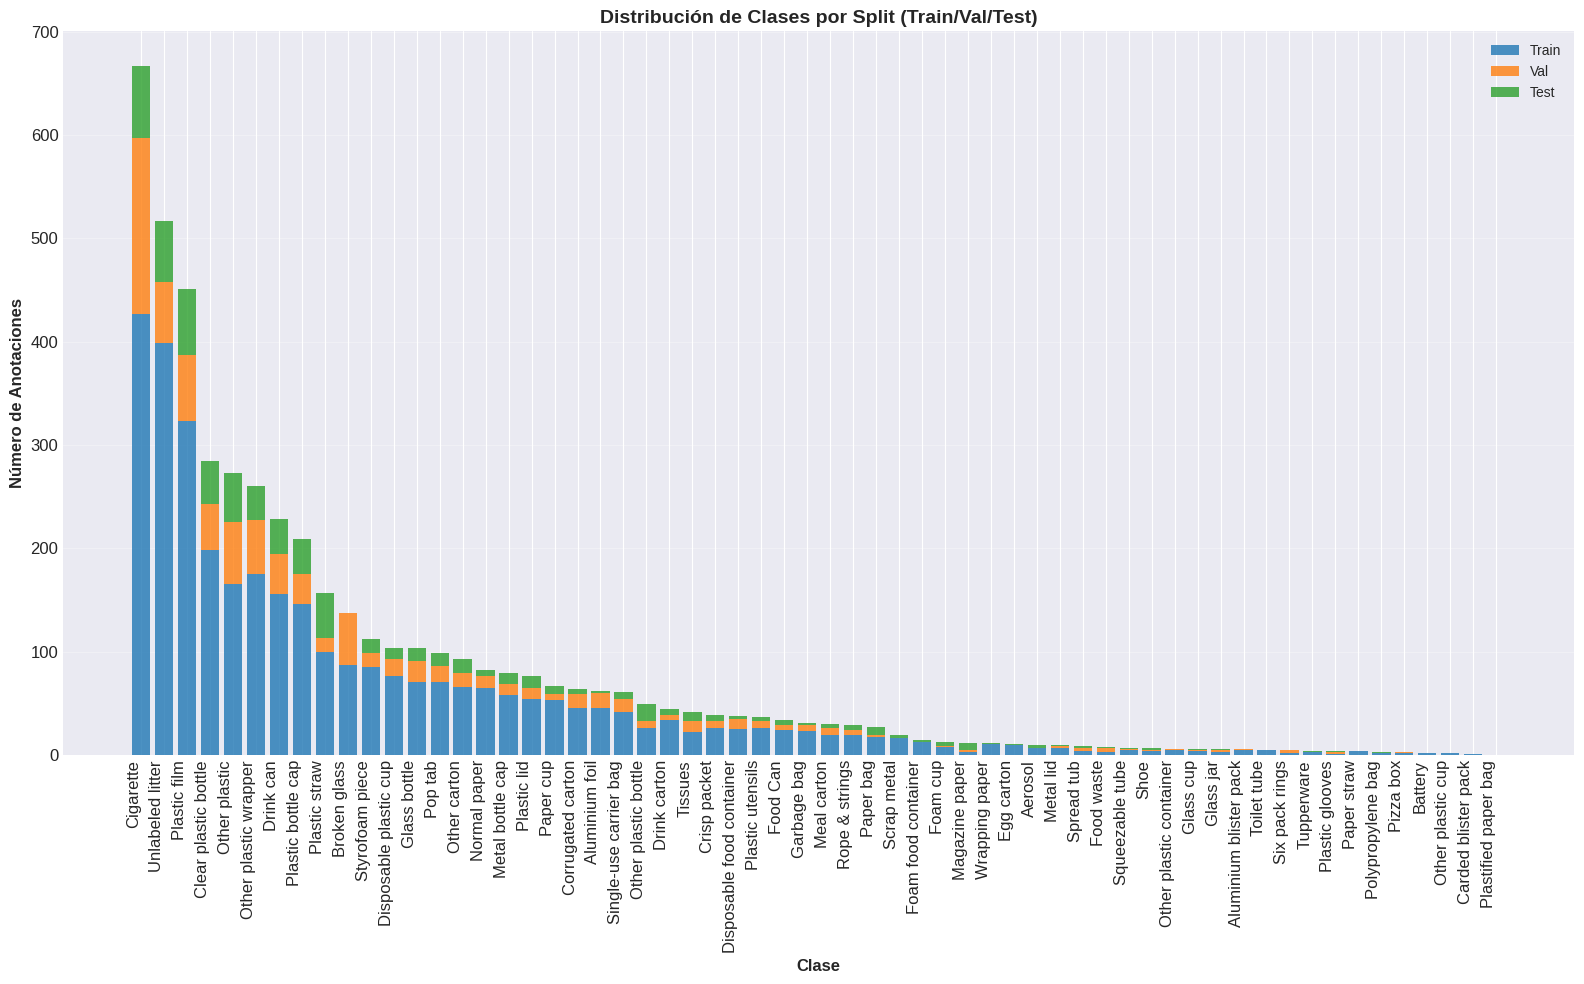


Total de anotaciones: 4784


In [34]:
# Gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(16, 10))
x = np.arange(len(df_distribution))
width = 0.8

ax.bar(x, df_distribution['Train'], width, label='Train', color='#1f77b4', alpha=0.8)
ax.bar(x, df_distribution['Val'], width, bottom=df_distribution['Train'], 
       label='Val', color='#ff7f0e', alpha=0.8)
ax.bar(x, df_distribution['Test'], width, 
       bottom=df_distribution['Train'] + df_distribution['Val'],
       label='Test', color='#2ca02c', alpha=0.8)

ax.set_xlabel('Clase', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Anotaciones', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Clases por Split (Train/Val/Test)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_distribution['Class'], rotation=90, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal de anotaciones: {df_distribution['Total'].sum()}")

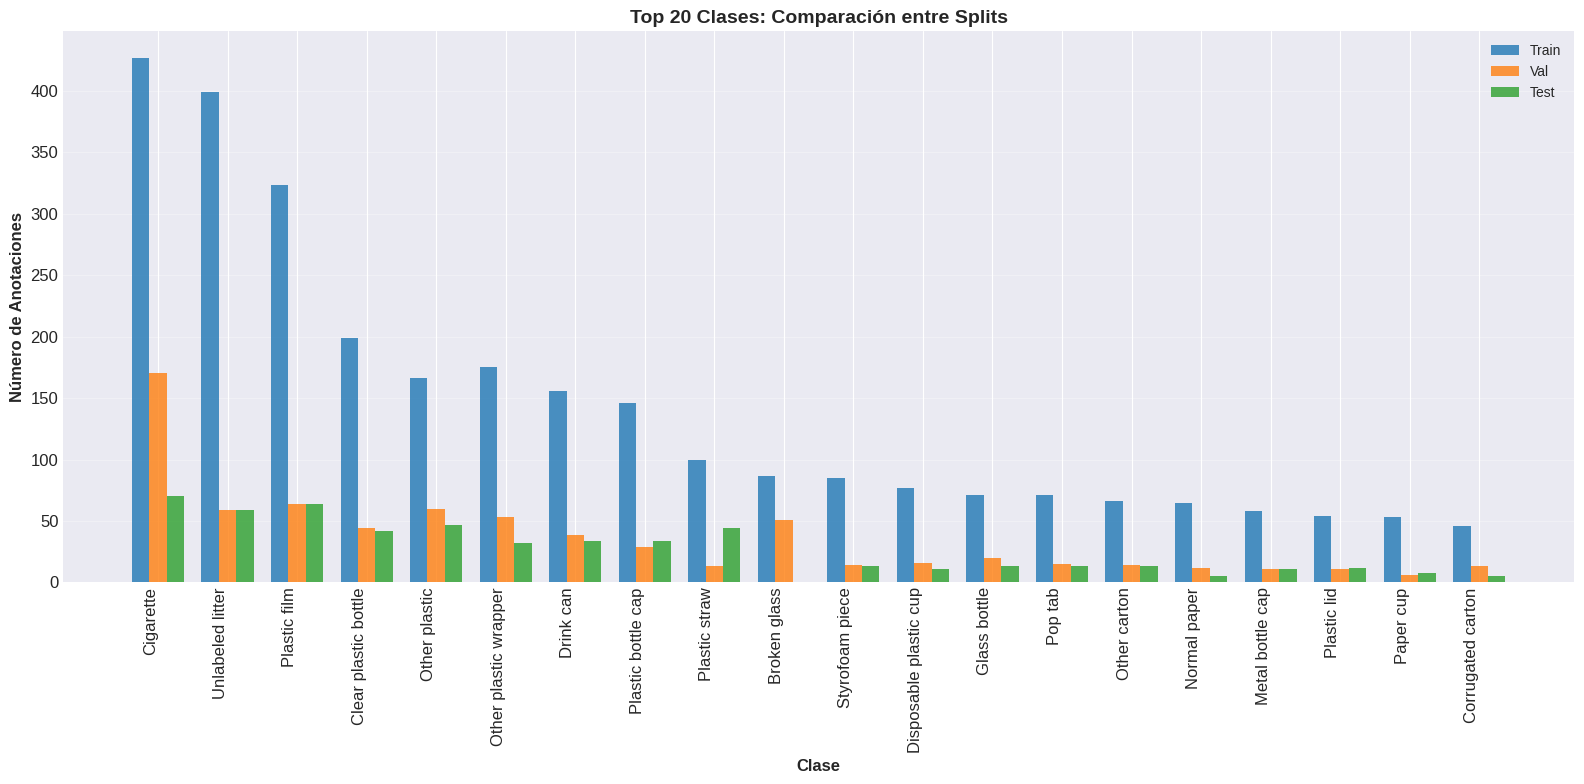

In [35]:
# Gráfico de barras agrupadas (comparación splits)
df_plot = df_distribution.head(20).copy()  # Top 20 clases

fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(len(df_plot))
width = 0.25

bars1 = ax.bar(x - width, df_plot['Train'], width, label='Train', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, df_plot['Val'], width, label='Val', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, df_plot['Test'], width, label='Test', color='#2ca02c', alpha=0.8)

ax.set_xlabel('Clase', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Anotaciones', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Clases: Comparación entre Splits', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Class'], rotation=90, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Métricas de Desbalanceo

In [36]:
# Calcular coeficiente de Gini para cada split
def gini_coefficient(counts):
    """Calcula el coeficiente de Gini (0=perfecto balance, 1=máximo desbalance)"""
    counts = np.array(sorted(counts))
    n = len(counts)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * counts)) / (n * np.sum(counts)) - (n + 1) / n

train_gini = gini_coefficient(list(train_counts.values()))
val_gini = gini_coefficient(list(val_counts.values()))
test_gini = gini_coefficient(list(test_counts.values()))

print("Coeficiente de Gini (0=balance perfecto, 1=desbalance máximo):")
print(f"  Train: {train_gini:.4f}")
print(f"  Val:   {val_gini:.4f}")
print(f"  Test:  {test_gini:.4f}")

# Calcular ratio de desbalanceo (max/min)
def imbalance_ratio(counts):
    values = [v for v in counts.values() if v > 0]
    if not values:
        return 0
    return max(values) / min(values)

train_ratio = imbalance_ratio(train_counts)
val_ratio = imbalance_ratio(val_counts)
test_ratio = imbalance_ratio(test_counts)

print(f"\nRatio de Desbalanceo (clase más frecuente / clase menos frecuente):")
print(f"  Train: {train_ratio:.2f}x")
print(f"  Val:   {val_ratio:.2f}x")
print(f"  Test:  {test_ratio:.2f}x")

# Identificar clases minoritarias (threshold configurable)
minority_threshold = 50
minority_classes = df_distribution[df_distribution['Total'] < minority_threshold]

print(f"\nClases minoritarias (< {minority_threshold} anotaciones): {len(minority_classes)}")
print(minority_classes[['Class', 'Train', 'Val', 'Test', 'Total']])

Coeficiente de Gini (0=balance perfecto, 1=desbalance máximo):
  Train: 0.6817
  Val:   0.7135
  Test:  0.6919

Ratio de Desbalanceo (clase más frecuente / clase menos frecuente):
  Train: 427.00x
  Val:   170.00x
  Test:  70.00x

Clases minoritarias (< 50 anotaciones): 37
                        Class  Train  Val  Test  Total
16               Drink carton     34    5     6     45
31                    Tissues     22   11     9     42
42               Crisp packet     26    7     6     39
45  Disposable food container     25   10     3     38
49           Plastic utensils     26    7     4     37
10                   Food Can     24    5     5     34
38                Garbage bag     23    6     2     31
18                Meal carton     20    6     4     30
51             Rope & strings     20    4     5     29
34                  Paper bag     18    2     7     27
52                Scrap metal     17    0     3     20
46        Foam food container     13    0     2     15
22         

## 6. Análisis de Clases Multi-Etiqueta

In [37]:
# Analizar imágenes con múltiples clases
def analyze_multilabel(data):
    # Contar clases por imagen
    image_classes = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in image_classes:
            image_classes[img_id] = set()
        image_classes[img_id].add(ann['category_id'])
    
    # Distribución de número de clases por imagen
    classes_per_image = [len(classes) for classes in image_classes.values()]
    
    return classes_per_image, image_classes

train_cpi, train_img_classes = analyze_multilabel(train_data)
val_cpi, val_img_classes = analyze_multilabel(val_data)
test_cpi, test_img_classes = analyze_multilabel(test_data)

print("Distribución de clases por imagen:")
print(f"\nTrain:")
print(f"  Promedio: {np.mean(train_cpi):.2f} clases/imagen")
print(f"  Min-Max:  {min(train_cpi)} - {max(train_cpi)}")
print(f"  Imágenes multi-clase: {sum(1 for c in train_cpi if c > 1)} ({sum(1 for c in train_cpi if c > 1)/len(train_cpi)*100:.1f}%)")

print(f"\nVal:")
print(f"  Promedio: {np.mean(val_cpi):.2f} clases/imagen")
print(f"  Min-Max:  {min(val_cpi)} - {max(val_cpi)}")
print(f"  Imágenes multi-clase: {sum(1 for c in val_cpi if c > 1)} ({sum(1 for c in val_cpi if c > 1)/len(val_cpi)*100:.1f}%)")

print(f"\nTest:")
print(f"  Promedio: {np.mean(test_cpi):.2f} clases/imagen")
print(f"  Min-Max:  {min(test_cpi)} - {max(test_cpi)}")
print(f"  Imágenes multi-clase: {sum(1 for c in test_cpi if c > 1)} ({sum(1 for c in test_cpi if c > 1)/len(test_cpi)*100:.1f}%)")

Distribución de clases por imagen:

Train:
  Promedio: 2.08 clases/imagen
  Min-Max:  1 - 13
  Imágenes multi-clase: 562 (53.6%)

Val:
  Promedio: 2.06 clases/imagen
  Min-Max:  1 - 7
  Imágenes multi-clase: 127 (56.2%)

Test:
  Promedio: 2.12 clases/imagen
  Min-Max:  1 - 7
  Imágenes multi-clase: 142 (63.1%)


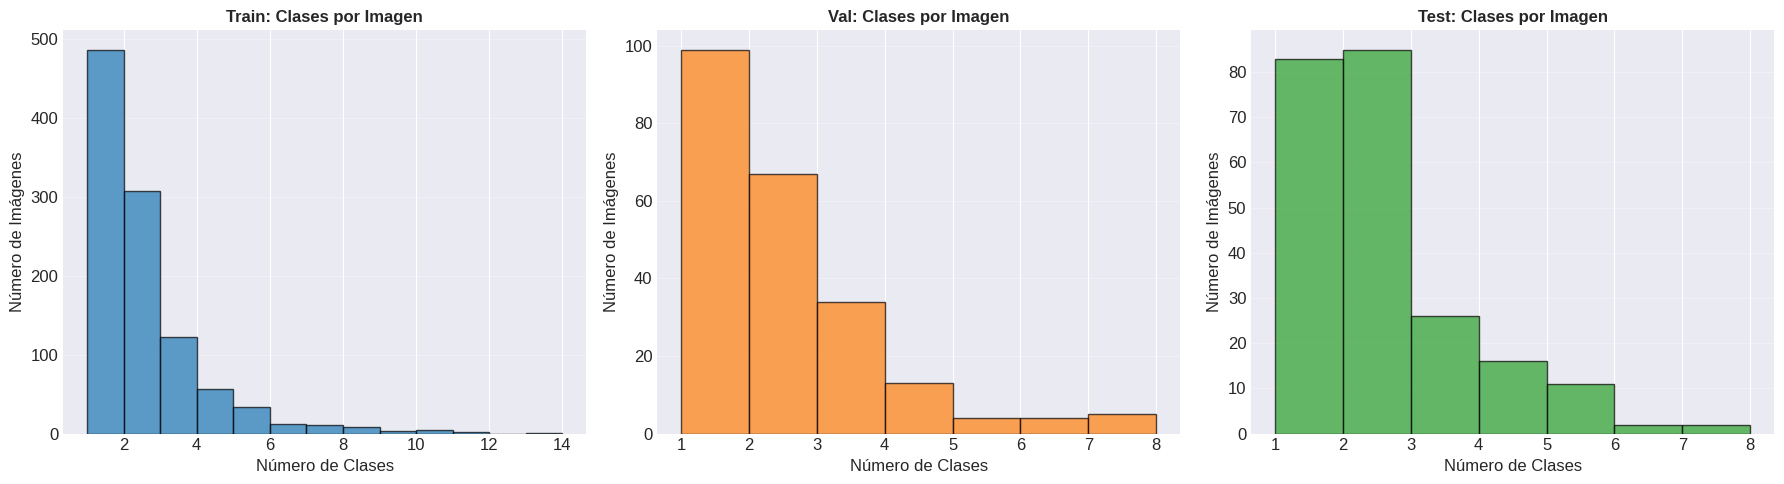

In [38]:
# Histograma de clases por imagen
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(train_cpi, bins=range(1, max(train_cpi)+2), alpha=0.7, color='#1f77b4', edgecolor='black')
axes[0].set_title('Train: Clases por Imagen', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Número de Clases')
axes[0].set_ylabel('Número de Imágenes')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(val_cpi, bins=range(1, max(val_cpi)+2), alpha=0.7, color='#ff7f0e', edgecolor='black')
axes[1].set_title('Val: Clases por Imagen', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Número de Clases')
axes[1].set_ylabel('Número de Imágenes')
axes[1].grid(axis='y', alpha=0.3)

axes[2].hist(test_cpi, bins=range(1, max(test_cpi)+2), alpha=0.7, color='#2ca02c', edgecolor='black')
axes[2].set_title('Test: Clases por Imagen', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Número de Clases')
axes[2].set_ylabel('Número de Imágenes')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Heatmap de Co-ocurrencia de Clases

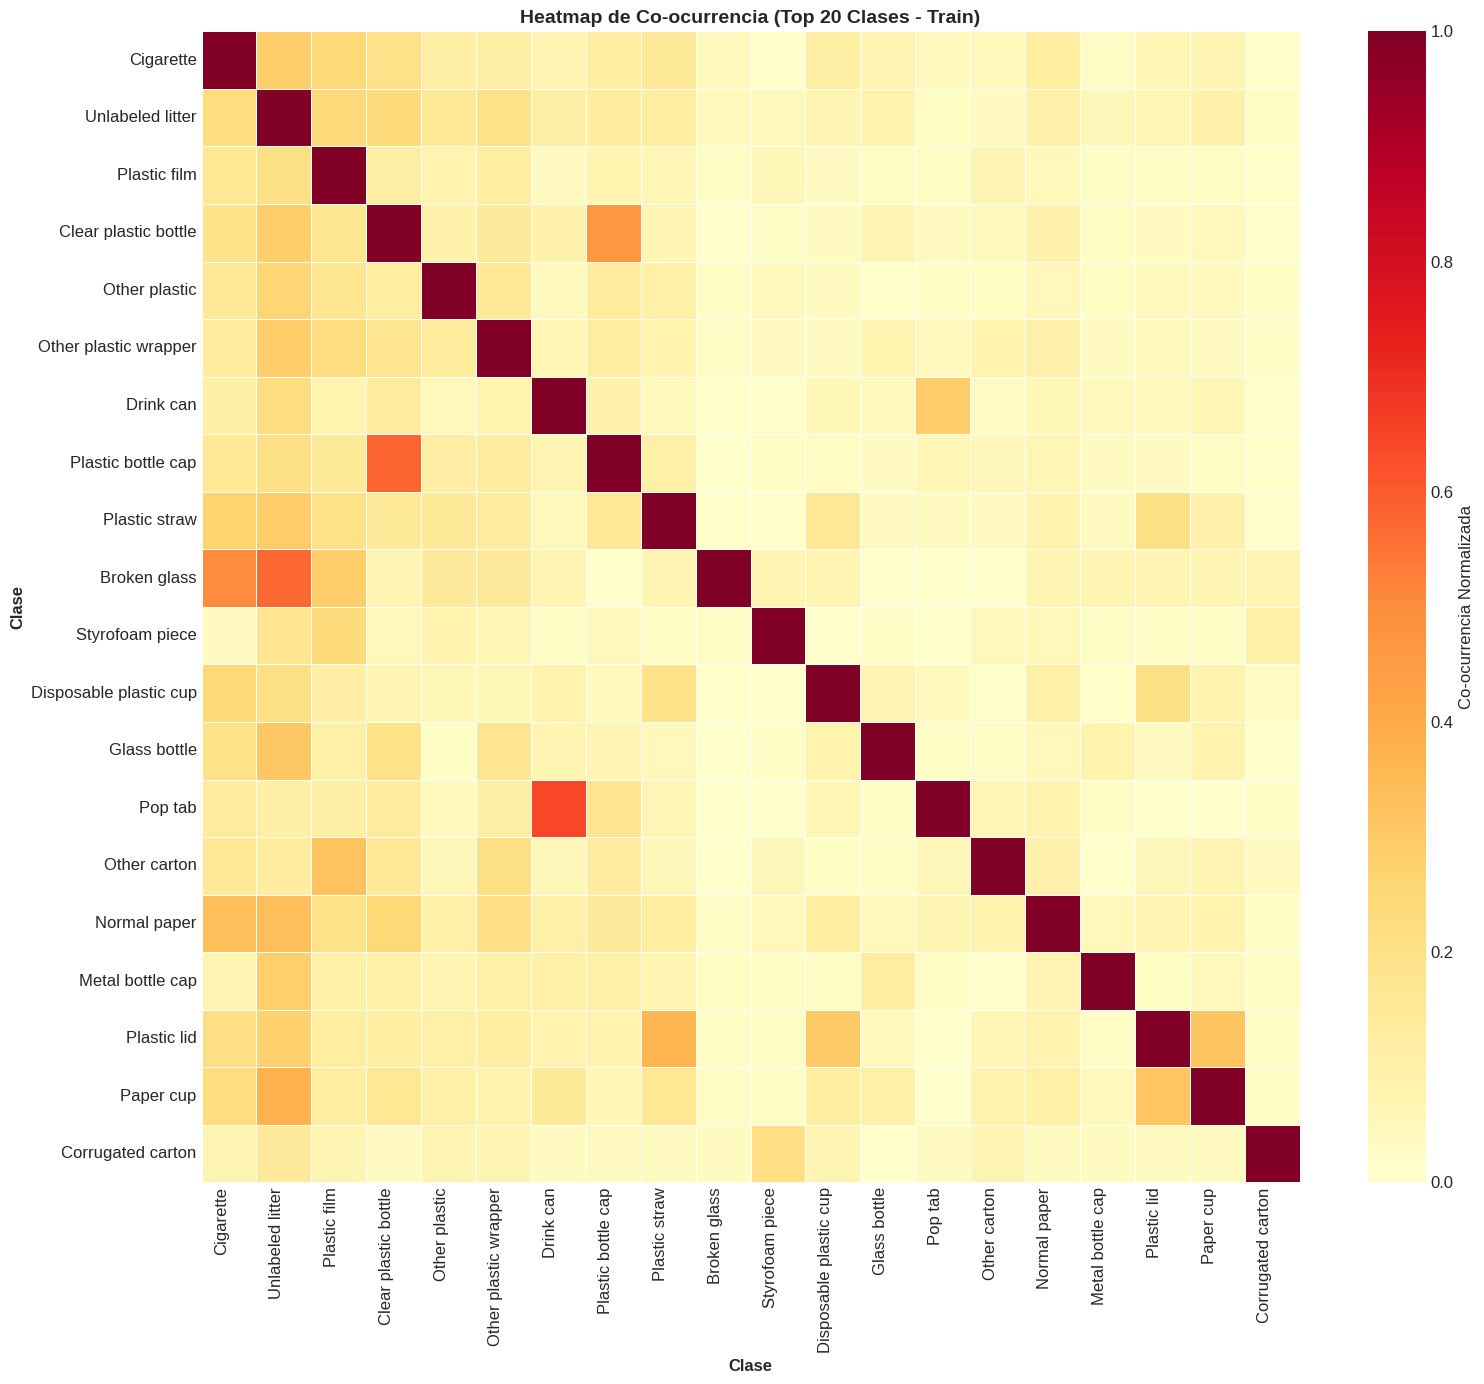

Valores cercanos a 1: clases que co-ocurren frecuentemente
Valores cercanos a 0: clases que raramente aparecen juntas


In [39]:
# Crear matriz de co-ocurrencia (solo para Train, Top 20 clases)
top_20_ids = [list(categories.keys())[list(categories.values()).index(name)] 
              for name in df_distribution.head(20)['Class'].values]

cooccurrence = np.zeros((len(top_20_ids), len(top_20_ids)))

for img_id, class_set in train_img_classes.items():
    classes_in_top20 = [c for c in class_set if c in top_20_ids]
    for i, c1 in enumerate(top_20_ids):
        for j, c2 in enumerate(top_20_ids):
            if c1 in classes_in_top20 and c2 in classes_in_top20:
                cooccurrence[i, j] += 1

# Normalizar por diagonal (auto-ocurrencia)
for i in range(len(top_20_ids)):
    if cooccurrence[i, i] > 0:
        cooccurrence[i, :] = cooccurrence[i, :] / cooccurrence[i, i]
        cooccurrence[:, i] = cooccurrence[:, i] / cooccurrence[i, i]

# Plot heatmap
top_20_names = [categories[cid] for cid in top_20_ids]

plt.figure(figsize=(16, 14))
sns.heatmap(cooccurrence, 
            xticklabels=top_20_names,
            yticklabels=top_20_names,
            cmap='YlOrRd',
            annot=False,
            fmt='.2f',
            cbar_kws={'label': 'Co-ocurrencia Normalizada'},
            linewidths=0.5)
plt.title('Heatmap de Co-ocurrencia (Top 20 Clases - Train)', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12, fontweight='bold')
plt.ylabel('Clase', fontsize=12, fontweight='bold')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Valores cercanos a 1: clases que co-ocurren frecuentemente")
print("Valores cercanos a 0: clases que raramente aparecen juntas")

## 8. Resumen y Recomendaciones

In [40]:
# Crear tabla resumen
summary_data = {
    'Métrica': [
        'Total Imágenes',
        'Total Anotaciones',
        'Clases con 0 muestras',
        'Clases Minoritarias (<50)',
        'Coeficiente Gini',
        'Ratio Desbalanceo',
        'Imágenes Multi-clase (%)'
    ],
    'Train': [
        len(train_data['images']),
        len(train_data['annotations']),
        sum(1 for v in train_counts.values() if v == 0),
        len([c for c in train_counts.values() if 0 < c < 50]),
        f"{train_gini:.4f}",
        f"{train_ratio:.2f}x",
        f"{sum(1 for c in train_cpi if c > 1)/len(train_cpi)*100:.1f}%"
    ],
    'Val': [
        len(val_data['images']),
        len(val_data['annotations']),
        sum(1 for v in val_counts.values() if v == 0),
        len([c for c in val_counts.values() if 0 < c < 50]),
        f"{val_gini:.4f}",
        f"{val_ratio:.2f}x",
        f"{sum(1 for c in val_cpi if c > 1)/len(val_cpi)*100:.1f}%"
    ],
    'Test': [
        len(test_data['images']),
        len(test_data['annotations']),
        sum(1 for v in test_counts.values() if v == 0),
        len([c for c in test_counts.values() if 0 < c < 50]),
        f"{test_gini:.4f}",
        f"{test_ratio:.2f}x",
        f"{sum(1 for c in test_cpi if c > 1)/len(test_cpi)*100:.1f}%"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("RESUMEN DEL DATASET:")
print(df_summary.to_string(index=False))

print("\n\nRECOMENDACIONES:")
print("\n1. DESBALANCEO ALTO:")
if train_gini > 0.6 or train_ratio > 100:
    print("   ADVERTENCIA: El dataset presenta un desbalanceo significativo")
    print("   Considera regenerar con: python scripts/prepare_data.py --stratify")
else:
    print("   OK: El desbalanceo está en niveles manejables")

print("\n2. CLASES MINORITARIAS:")
num_minority = len(minority_classes)
if num_minority > len(categories) * 0.3:
    print(f"   ADVERTENCIA: {num_minority} clases tienen < {minority_threshold} anotaciones")
    print("   Considera usar: --duplicate-multi-label para aumentar muestras")
    print("   Ajusta --minority-threshold según necesidad")
else:
    print(f"   OK: Solo {num_minority} clases minoritarias")

print("\n3. CLASES CON 0 MUESTRAS EN SPLITS:")
zero_train = sum(1 for v in train_counts.values() if v == 0)
zero_val = sum(1 for v in val_counts.values() if v == 0)
zero_test = sum(1 for v in test_counts.values() if v == 0)
if zero_train > 0 or zero_val > 0 or zero_test > 0:
    print(f"   ADVERTENCIA: Train: {zero_train}, Val: {zero_val}, Test: {zero_test} clases sin muestras")
    print("   USAR: --stratify es CRÍTICO para garantizar representación")
else:
    print("   OK: Todas las clases representadas en todos los splits")

RESUMEN DEL DATASET:
                  Métrica   Train     Val   Test
           Total Imágenes    1049     226    225
        Total Anotaciones    3309     835    640
    Clases con 0 muestras       1      13     11
Clases Minoritarias (<50)      40      41     46
         Coeficiente Gini  0.6817  0.7135 0.6919
        Ratio Desbalanceo 427.00x 170.00x 70.00x
 Imágenes Multi-clase (%)   53.6%   56.2%  63.1%


RECOMENDACIONES:

1. DESBALANCEO ALTO:
   ADVERTENCIA: El dataset presenta un desbalanceo significativo
   Considera regenerar con: python scripts/prepare_data.py --stratify

2. CLASES MINORITARIAS:
   ADVERTENCIA: 37 clases tienen < 50 anotaciones
   Considera usar: --duplicate-multi-label para aumentar muestras
   Ajusta --minority-threshold según necesidad

3. CLASES CON 0 MUESTRAS EN SPLITS:
   ADVERTENCIA: Train: 1, Val: 13, Test: 11 clases sin muestras
   USAR: --stratify es CRÍTICO para garantizar representación
